In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

from scipy.stats import shapiro, levene, rankdata, linregress, kruskal

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from matplotlib.ticker import FuncFormatter

import helper

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:165: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:186: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [4]:
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric="avefits"
season_len = 300
num_reps=15
root="~/CA_GRN_results/detailed_save/"#extra_inputs/"
#root="~/scratch/non_detailed_save/extra_inputs/"
id_start=0
seed_ints = seed_intss[0]

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

mylines=False

s1drops=[]
s2drops=[]
fitdeltas1=[]
fitdeltas2=[]

c=0
for si in seed_intss:
    if c==0:
        myroot=root
    elif c==1:
        myroot="~/CA_GRN_results/non_detailed_save/"#extra_inputs/"
    else:
        myroot="~/CA_GRN_results/non_detailed_save/extra_inputs/"
    c+=1
    for rule in rules:
        #fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
        all_maxs=helper.get_fits([rule,rule], si, metric, myroot, season_len, num_reps, id_start, extrapolate=True)
        all_maxs=np.array(all_maxs)
        labels=["Variable","Static 1","Static 2"]
        colors = ["green", "lightblue", "orange"]
        z_value = 1.96  # For a 95% confidence interval

        m=all_maxs[0]
        mean1 = m.copy() #np.mean(m, axis=0)

        # HOW MUCH THEY DROP?
        season_starts1 = mean1[:,::300][:,1:][:,1::2]
        season_starts2 = mean1[:,::300][:,1:][:,::2]
        
        s1drops.append(season_starts1)
        s2drops.append(season_starts2)

        # HOW FAST FITNESS INCREASE
        s1_x_gens_late_idx = np.arange(0,9899)[300::300][1::2] -1
        s2_x_gens_late_idx = np.arange(0,9899)[300::300][::2] -1
        fit_delta1 = mean1[:,s1_x_gens_late_idx] - season_starts1
        fit_delta2 = mean1[:,s2_x_gens_late_idx] - season_starts2 
        
        fitdeltas1.append(fit_delta1)
        fitdeltas2.append(fit_delta2)

        print(rule)



    

22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102
22
126
154
18
122
70
54
94
30
50
62
110
90
150
102


In [14]:
np.array(fitdeltas1).mean(axis=1).shape

(105, 16)

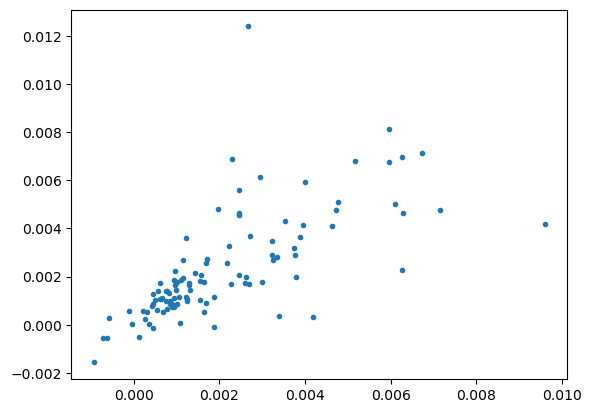

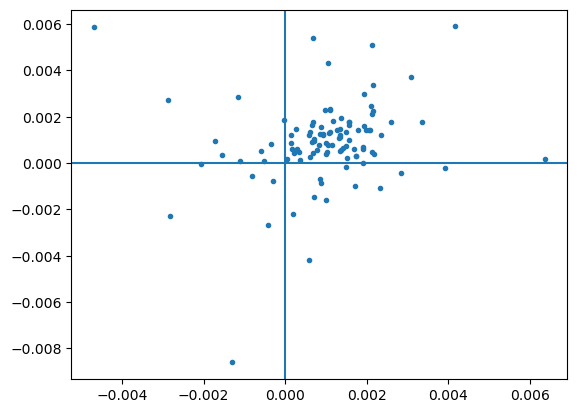

In [36]:
def get_slopes(xs):
    outs=[]
    for i in range(105):
        slope, intercept = np.polyfit(np.arange(0,len(xs[i])), xs[i], 1)
        outs.append(slope)
    return outs


labels=[str(rule)+str(init) for rule, init in zip(np.array(seed_intss).repeat(len(rules),axis=0),rules * len(seed_intss)) ]
#labels=rules

dropx=get_slopes(np.array(s1drops).mean(axis=1))
dropy=get_slopes(np.array(s2drops).mean(axis=1))
plt.plot(dropx,dropy,".")
#for xi, yi, label in zip(x, y, labels):
    #plt.text(xi, yi, label, fontsize=12, ha='right', va='bottom')
plt.show()

fdx=get_slopes(np.array(fitdeltas1).mean(axis=1))
fdy=get_slopes(np.array(fitdeltas2).mean(axis=1))
plt.plot(fdx,fdy,".")
plt.axvline(0)
plt.axhline(0)
# #for xi, yi, label in zip(x, y, rules):
#     #plt.text(xi, yi, label, fontsize=12, ha='right', va='bottom')
plt.show()




In [16]:
np.array(s1drops).shape

(105, 15, 16)

In [28]:

s1drops = np.array(s1drops)
s2drops = np.array(s2drops)
fitdeltas1 = np.array(fitdeltas1)
fitdeltas2 = np.array(fitdeltas2)

signs=[]
for t in [s1drops, s2drops, fitdeltas1, fitdeltas2]:
    pdic = []
    for r in range(105):
        curr_rule = t[r, :, :]
        slopes = []
        for rep in range(15):
            ys = curr_rule[rep, :]
            xs = np.arange(len(ys))
            slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
            slopes.append(slope)
        slopes = np.array(slopes)
        # Now test if the average slope is significantly greater than zero
        #This is a test for the null hypothesis that the expected value (mean) of a sample of 
        # independent observations _slopes_ is equal to the given number, 0.
        t_stat, p_val = stats.ttest_1samp(slopes, 0)

        #print("Mean slope across replicates:", slopes.mean())
        #print("p-value (|slope| > 0):", p_val)

        pdic.append(p_val)
    fdr = multipletests(np.array(pdic), method='fdr_bh')[1]

    print(len([f for f in fdr if f <0.05]))
    signs.append(np.where(fdr<0.05)[0])

76
80
62
53


In [40]:
dropx

[-0.00070538515443533,
 0.0007794729254859503,
 0.006274532961595735,
 0.00045287812838349175,
 0.004196333699465614,
 0.006737708818294434,
 0.009597285719425268,
 0.0018794994214349143,
 0.0011156616747113304,
 0.0026820727333173615,
 0.002238524577304671,
 0.0009721269100495347,
 0.0034013541446628855,
 0.0022702516969894193,
 0.007153697065514554,
 0.00036839426534251036,
 0.0016551617970415426,
 0.0024626163078340906,
 -0.0009296229389498489,
 0.00050009908083193,
 0.005175516588301526,
 0.00156894696365296,
 0.0011505042009950488,
 0.00168660399054776,
 0.0029981910921789185,
 -0.0006154863643393745,
 0.000981184377152016,
 0.0009457597176140217,
 0.0004217227336675856,
 0.0006394482113669934,
 0.0005413544503082743,
 0.0009329419963903931,
 0.003951617357228022,
 0.000625248347183064,
 0.0009772571437009242,
 0.004726200847919569,
 0.0026022376973889286,
 0.002960868309462093,
 0.0021876210048825525,
 0.0026289232386417266,
 0.0037576373484614787,
 0.0033552706135062927,
 0.0007

In [35]:
s1drops.shape

(105, 15, 16)

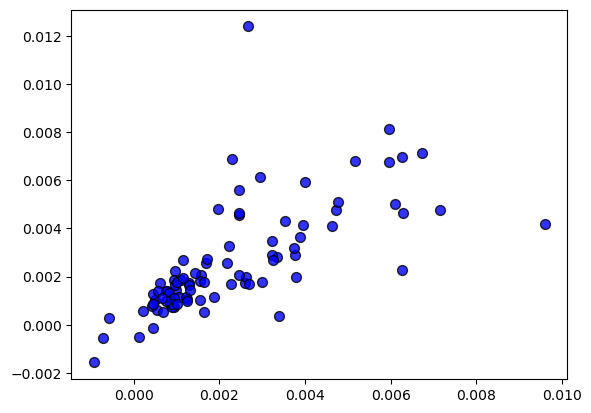

In [41]:
drops_sign=np.concatenate([signs[0],signs[1]])
drops_sign=np.unique(drops_sign)

plt.scatter(np.array(dropx)[drops_sign],np.array(dropy)[drops_sign],marker="o", color="blue", s=50,edgecolor="black", alpha=0.8)

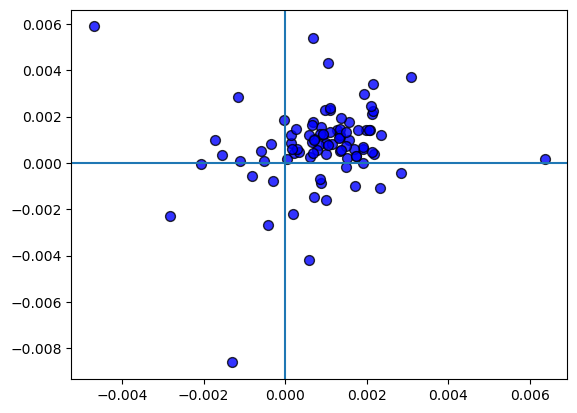

In [43]:
fd_sign=np.concatenate([signs[2],signs[3]])
fd_sign=np.unique(drops_sign)

plt.scatter(np.array(fdx)[fd_sign],np.array(fdy)[fd_sign],marker="o", color="blue", s=50,edgecolor="black", alpha=0.8)
plt.axvline(0)
plt.axhline(0)